In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import time
import math
import random
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
# Load data
"""data = np.load("../data/data_1.npy")
labels = np.load("../data/labels_1.npy")

data = np.vstack((data,np.load("../data/data_2.npy")))
labels = np.vstack((labels,np.load("../data/labels_2.npy")))

data = np.vstack((data,np.load("../data/data_3.npy")))
labels = np.vstack((labels,np.load("../data/labels_3.npy")))

data = np.vstack((data,np.load("../data/data_4.npy")))
labels = np.vstack((labels,np.load("../data/labels_4.npy")))

data = np.vstack((data,np.load("../data/data_5.npy")))
labels = np.vstack((labels,np.load("../data/labels_5.npy")))
"""
data = np.load("../data/images.npy")
data = torch.FloatTensor(np.expand_dims(data,axis=1))/255.
data_permuts = torch.randperm(data.shape[0])
data = data[data_permuts,:]
labels = torch.FloatTensor(np.load("../data/labels.npy"))
labels = labels[data_permuts,:]

print(f"data: {data.shape}, labels: {labels.shape}")

data: torch.Size([18000, 1, 150, 150]), labels: torch.Size([18000, 2])


<br/>
<h3>Labels transformation to cyclical</h3>

In [3]:
#we will use a dataframe to change the labels since it is more convenient.
labels_df = pd.DataFrame(labels,columns=['hour', 'minute'])
labels_df['h_cos'] = np.cos(2 * np.pi * labels_df["hour"] / labels_df["hour"].max())
labels_df['h_sin'] = np.sin(2 * np.pi * labels_df["hour"] / labels_df["hour"].max())
labels_df['m_cos'] = np.cos(2 * np.pi * labels_df["minute"] / labels_df["minute"].max())
labels_df['m_sin'] = np.sin(2 * np.pi * labels_df["minute"] / labels_df["minute"].max())

labels_cycl = torch.FloatTensor(labels_df.to_numpy())

<br/>
<h3>Dataset creation</h3>

In [4]:
class ClockDataset(Dataset):
    """ Class used to create the pytorch DataLoaders.
    """
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [5]:
# Create main dataset
clock_dataset = ClockDataset(data, labels_cycl)
train_data, test_data, val_data = random_split(clock_dataset, [14000,3000,1000])

# Split dataset into train, test and validation sets
train_data_loader = DataLoader(train_data, batch_size=64)
test_data_loader = DataLoader(test_data, batch_size=64)
val_data_loader = DataLoader(val_data, batch_size=64)

In [6]:
for X, y in train_data:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([1, 150, 150])
Shape of y: torch.Size([6]) torch.float32


<br/>
<h3>Model creation</h3>

In [7]:
class NN_regression(nn.Module):
    """ Convolution model that returns one value as output.
    """
    def __init__(self, input_channels, h, w, n_outputs):
        super(NN_regression, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16)
        )
        self.hidden_layers = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=2),
            nn.Dropout(0.2),
            nn.Flatten()
        )
        self.output_layer = nn.Sequential(
            nn.Linear(32768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, n_outputs)    
        )

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return x

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    """ Main train step with weight update
    """
    losses = []
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y[:, 2:].to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss)
    losses = torch.FloatTensor(losses)
    return losses

In [9]:
def evaluate(dataloader, model, loss_fn):
    """ Main evaluation function during training
    """
    model.eval()
    losses = []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y[:, 2:].to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            losses.append(loss)
    losses = torch.FloatTensor(losses)
    return losses

<h4>Main model training step</h4>

In [10]:
model = NN_regression(input_channels=1,h=150,w=150, n_outputs=4).to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10

# Main training step
train_losses = []
test_losses = []
mean_test_loss = np.inf
start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # Training step
    train_l = train(train_data_loader, model, loss, optimizer)
    train_mean = torch.mean(train_l)
    train_losses.append(train_mean)
    print(f"Train loss: {train_mean:>7f}")

    # Evaluation step
    test_l = evaluate(val_data_loader, model, loss)
    test_mean = torch.mean(test_l)
    test_losses.append(test_mean)
    print(f"Test avg loss: {test_mean:>8f} \n")

    # Save new weights if they are better
    if test_mean < mean_test_loss:
        print("New best found. Saving the weights.")
        mean_test_loss = test_mean
        torch.save(model.state_dict(), "../model_weights/weights-test")
end_time = time.time()

Epoch 1
-------------------------------
Train loss: 0.435845
Test avg loss: 0.331199 

New best found. Saving the weights.
Epoch 2
-------------------------------
Train loss: 0.308106
Test avg loss: 0.275024 

New best found. Saving the weights.
Epoch 3
-------------------------------
Train loss: 0.271867
Test avg loss: 0.247284 

New best found. Saving the weights.
Epoch 4
-------------------------------
Train loss: 0.239811
Test avg loss: 0.200253 

New best found. Saving the weights.
Epoch 5
-------------------------------
Train loss: 0.189067
Test avg loss: 0.146846 

New best found. Saving the weights.
Epoch 6
-------------------------------
Train loss: 0.142465
Test avg loss: 0.112004 

New best found. Saving the weights.
Epoch 7
-------------------------------
Train loss: 0.110921
Test avg loss: 0.089198 

New best found. Saving the weights.
Epoch 8
-------------------------------
Train loss: 0.089239
Test avg loss: 0.076603 

New best found. Saving the weights.
Epoch 9
--------

In [11]:
x = np.vstack(train_losses)
y = np.vstack(test_losses)

(10, 1)

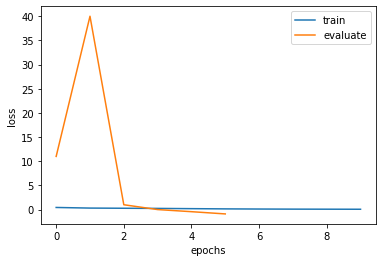

In [23]:
plt.plot(x, label="train")
plt.plot(y, label="evaluate")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.save

<h4>Test our model with unseen data</h4>

In [12]:
def predict(dataloader, model, loss_fn):
    """ Returns predictions for the data in the DataLoader 
        as a flattened numpy array.
    """
    losses = []
    predictions = []
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y[:,2:].to(device)
            pred = model(X)
            predictions.append(pred.cpu().numpy())
            loss = loss_fn(pred, y)
            losses.append(loss)
    losses = torch.FloatTensor(losses)
    print(f"Avg evaluation loss: {torch.mean(losses):>8f} \n")

    # Normalize values bigger than the threshold
    predictions  = np.vstack(predictions)
    predictions[ predictions > 1 ] = 1
    predictions[ predictions < -1 ] = -1
    return predictions

predictions = predict(test_data_loader, model, loss)
print("Predictions shape:",predictions.shape)

Avg evaluation loss: 0.060736 

Predictions shape: (3000, 4)


In [13]:
targets = []
for i in range(len(test_data)):
    targets.append(test_data[i][1])
targets = np.vstack(targets)
print("Targets shape",targets.shape)

Targets shape (3000, 6)


In [14]:
def denormalize_time(predictions):
    """ returns the corresponding hour and minute predictions
        from the sine and cosine values
    """
    true_preds = []
    for h_cos,h_sin,m_cos,m_sin in predictions:
        h_angle = math.atan2(h_sin, h_cos)
        h_angle *= 180 / math.pi
        if h_angle < 0: h_angle += 360

        m_angle = math.atan2(m_sin, m_cos)
        m_angle *= 180 / math.pi
        if m_angle < 0: m_angle += 360

        true_hour = math.modf(h_angle/30)[1]
        true_mins = math.modf(m_angle/6)[1]
        true_preds.append([true_hour, true_mins])
    return torch.FloatTensor(true_preds)

true_preds = denormalize_time(predictions)
print("True predictions shape:",true_preds.shape)

True predictions shape: torch.Size([3000, 2])


<br/>
<h4>Define common sense error and calculate it on test dataset.</h4>

In [15]:
class CommonSenseError(nn.Module):
    def __init__(self):
        super(CommonSenseError, self).__init__()

    def forward(self, prediction, target):
        # hour common sense error in minutes
        preds = torch.floor(prediction.T)
        labels = target.T
        hour_start_idx = torch.minimum(preds[0], labels[0])
        hour_end_idx = torch.maximum(preds[0], labels[0])
        hour_dist_1 = (hour_end_idx - hour_start_idx)
        hour_dist_2 = hour_start_idx + 12 - hour_end_idx
        hour_dist = torch.minimum(hour_dist_1, hour_dist_2) * 60  # we want the common error to be in minutes

        # minutes common sense error
        mins_start_idx = torch.minimum(preds[1], labels[1])
        mins_end_idx = torch.maximum(preds[1], labels[1])
        mins_dist_1 = (mins_end_idx - mins_start_idx)
        mins_dist_2 = mins_start_idx + 60 - mins_end_idx
        mins_dist = torch.minimum(mins_dist_1, mins_dist_2)

        # return total common sense error in minutes
        return torch.mean(hour_dist + mins_dist)


a = torch.Tensor([[1,14], [4,28], [2,36], [1,1]])
b = torch.Tensor([[1,15], [3,29], [2,36], [11,59]])
cse = CommonSenseError()
cse.forward(a,b)

tensor(46.)

In [16]:
cse_err = cse(torch.FloatTensor(true_preds),torch.FloatTensor(targets[:,:2]))
print(f"Common sense error: {cse_err}")

Common sense error: 25.610000610351562
